# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Importing Relevant Libraries

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import PIL
import numpy as np
import os
import cv2
from cv2 import imread
from cv2 import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

<b>I have used my local machine to work on this notebook, therefore all the paths / directories have been laid out in accordance.</b>

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

By experimenting with various batch sizes we came to the conclusion that anything beyond 32 gives us a resource exhaust error

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
import abc

class ModGen(metaclass= abc.ABCMeta):
    
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
        self.val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
        self.train_path = 'Project_data/train'
        self.val_path = 'Project_data/val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
    
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        
        global history
        
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        
        
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [5]:
# Defining a function to make a plot of losses and Accuracies between training and validation set 

def acc_plot(x):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(x)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')
    plt.show()
    


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/train'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Conv3D Models

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dropout,Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

class base_model(ModGen):                           # Making a base model
    
    def define_model(self):

        model = Sequential()


        model.add(Conv3D(16, kernel_size = (3,3,3),padding = 'Same', activation ='relu', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels))) 
        model.add(BatchNormalization())                                                         
        model.add(MaxPooling3D(pool_size=(2,2,2)))


        model.add(Conv3D(32, kernel_size = (3,3,3),padding = 'Same', activation ='relu')) 
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))          


        model.add(Conv3D(64, kernel_size = (3,3,3),padding = 'Same', activation ='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))          
        
        
        model.add(Conv3D(64, kernel_size = (3,3,3),padding = 'Same', activation ='relu'))
        model.add(BatchNormalization())
        
        
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())


        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    
    


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Before we make any full model run let us try and experiment with some hyper parameters while running ablations.

for this purpose lets keep number of epochs limited to 3.

First lets experiment with number of frames/images to be used.

#### Model 1 - Ablation

Model 1 with batch size 32 and 10 frames/images to be used 

In [8]:
num_epochs = 3

In [9]:
m1=base_model()
m1.initialize_path('Project_data')
m1.initialize_image_properties(image_height=120,image_width=120)
m1.initialize_hyperparams(frames_to_sample=10,batch_size=32,num_epochs=num_epochs)
m1_ab=m1.define_model()
m1_ab.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 30, 30, 64)     5

In [10]:
model_1_ab = m1.train_model(m1_ab)

Epoch 1/3
21/21 [==============================] - 26s 539ms/step - loss: 1.6311 - categorical_accuracy: 0.4966 - val_loss: 1.8303 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2022-05-1113_36_19.453001\model-00001-1.29814-0.58824-1.83033-0.23000.h5
Epoch 2/3
21/21 [==============================] - 11s 524ms/step - loss: 0.4404 - categorical_accuracy: 0.8422 - val_loss: 3.4504 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-05-1113_36_19.453001\model-00002-0.39869-0.84917-3.45041-0.20000.h5
Epoch 3/3
21/21 [==============================] - 11s 520ms/step - loss: 0.2055 - categorical_accuracy: 0.9278 - val_loss: 4.0928 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2022-05-1113_36_19.453001\model-00003-0.22557-0.92006-4.09283-0.22000.h5


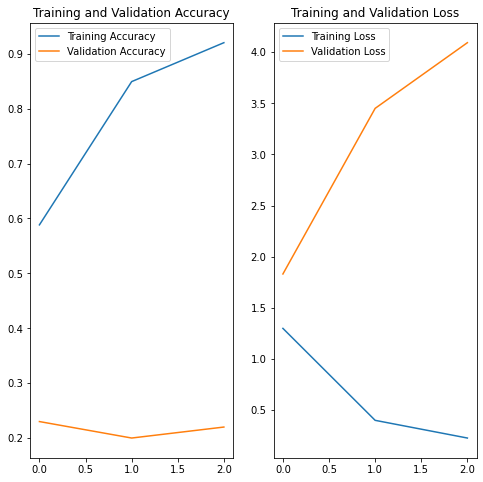

In [11]:
acc_plot(num_epochs)

#### Model 2 - Ablation

Model 2 with batch size 32 and 15 number of frames/images to be used 

In [12]:
m2=base_model()
m2.initialize_path('Project_data')
m2.initialize_image_properties(image_height=120,image_width=120)
m2.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=num_epochs)
m2_ab=m2.define_model()
m2_ab.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 3, 30, 30, 64)    

In [13]:
model_2_ab = m2.train_model(m2_ab)

Epoch 1/3
21/21 [==============================] - 18s 789ms/step - loss: 1.7354 - categorical_accuracy: 0.4756 - val_loss: 1.9581 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_2022-05-1113_37_07.952984\model-00001-1.42862-0.53394-1.95811-0.19000.h5
Epoch 2/3
21/21 [==============================] - 16s 786ms/step - loss: 0.5399 - categorical_accuracy: 0.7831 - val_loss: 2.8666 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-05-1113_37_07.952984\model-00002-0.47166-0.80995-2.86658-0.20000.h5
Epoch 3/3
21/21 [==============================] - 16s 778ms/step - loss: 0.2775 - categorical_accuracy: 0.8953 - val_loss: 3.5664 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2022-05-1113_37_07.952984\model-00003-0.26565-0.91252-3.56641-0.24000.h5


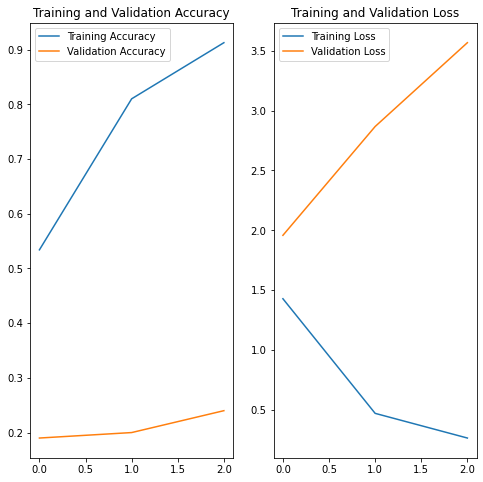

In [14]:
acc_plot(num_epochs)

#### Model 3 - Ablation

Model 3 with batch size 32 and 20 number of frames/images to be used 

In [15]:
m3=base_model()
m3.initialize_path('Project_data')
m3.initialize_image_properties(image_height=120,image_width=120)
m3.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=num_epochs)
m3_ab=m3.define_model()
m3_ab.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_10 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 5, 30, 30, 64)    

In [16]:
model_3_ab = m3.train_model(m3_ab)

Epoch 1/3
21/21 [==============================] - 23s 1s/step - loss: 1.6486 - categorical_accuracy: 0.4828 - val_loss: 2.5095 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2022-05-1113_37_59.172945\model-00001-1.25441-0.58673-2.50947-0.20000.h5
Epoch 2/3
21/21 [==============================] - 21s 1s/step - loss: 0.3856 - categorical_accuracy: 0.8572 - val_loss: 3.2944 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-05-1113_37_59.172945\model-00002-0.40342-0.84615-3.29441-0.20000.h5
Epoch 3/3
21/21 [==============================] - 21s 1s/step - loss: 0.2562 - categorical_accuracy: 0.9171 - val_loss: 4.8833 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to model_init_2022-05-1113_37_59.172945\model-00003-0.29048-0.90045-4.88330-0.15000.h5


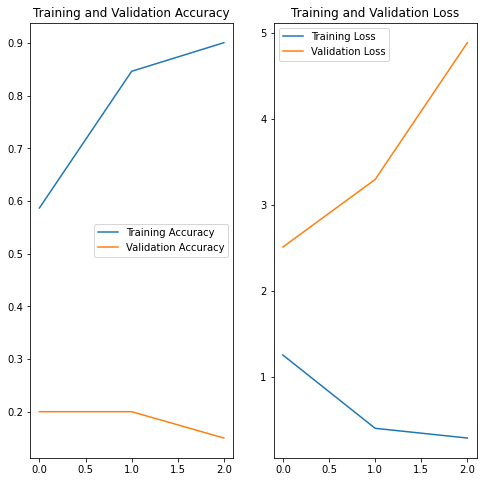

In [17]:
acc_plot(num_epochs)

#### Model 4 - Ablation

Model 4 with batch size 32 and 24 number of frames/images to be used 

In [18]:
m4=base_model()
m4.initialize_path('Project_data')
m4.initialize_image_properties(image_height=120,image_width=120)
m4.initialize_hyperparams(frames_to_sample=24,batch_size=32,num_epochs=num_epochs)
m4_ab=m4.define_model()
m4_ab.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 24, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 12, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 6, 30, 30, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 6, 30, 30, 64)    

In [19]:
model_4_ab = m4.train_model(m4_ab)

Epoch 1/3
21/21 [==============================] - 28s 1s/step - loss: 1.8384 - categorical_accuracy: 0.4563 - val_loss: 2.8976 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2022-05-1113_39_05.640240\model-00001-1.36130-0.55958-2.89761-0.27000.h5
Epoch 2/3
21/21 [==============================] - 26s 1s/step - loss: 0.3868 - categorical_accuracy: 0.8617 - val_loss: 4.5338 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-05-1113_39_05.640240\model-00002-0.39027-0.85520-4.53384-0.20000.h5
Epoch 3/3
21/21 [==============================] - 26s 1s/step - loss: 0.2051 - categorical_accuracy: 0.9363 - val_loss: 4.7781 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2022-05-1113_39_05.640240\model-00003-0.21564-0.92609-4.77810-0.20000.h5


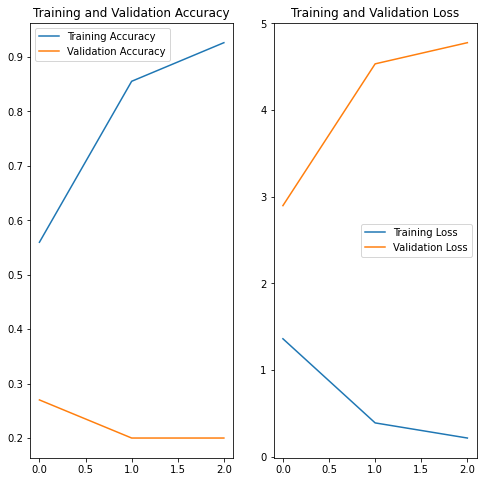

In [20]:
acc_plot(num_epochs)

#### Model 5 - Ablation

Model 5 with batch size 32 and 30 number of frames/images to be used 

In [21]:
m5=base_model()
m5.initialize_path('Project_data')
m5.initialize_image_properties(image_height=120,image_width=120)
m5.initialize_hyperparams(frames_to_sample=30,batch_size=32,num_epochs=num_epochs)
m5_ab=m5.define_model()
m5_ab.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_20 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_21 (Batc (None, 15, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 7, 30, 30, 64)    

In [22]:
model_5_ab = m5.train_model(m5_ab)

Epoch 1/3
21/21 [==============================] - 35s 2s/step - loss: 1.6712 - categorical_accuracy: 0.5004 - val_loss: 5.6348 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-05-1113_40_27.233490\model-00001-1.29339-0.58824-5.63480-0.16000.h5
Epoch 2/3
21/21 [==============================] - 33s 2s/step - loss: 0.4849 - categorical_accuracy: 0.8301 - val_loss: 6.7548 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2022-05-1113_40_27.233490\model-00002-0.44896-0.83409-6.75485-0.18000.h5
Epoch 3/3
21/21 [==============================] - 32s 2s/step - loss: 0.2284 - categorical_accuracy: 0.9358 - val_loss: 9.1907 - val_categorical_accuracy: 0.1100

Epoch 00003: saving model to model_init_2022-05-1113_40_27.233490\model-00003-0.21937-0.92760-9.19072-0.11000.h5


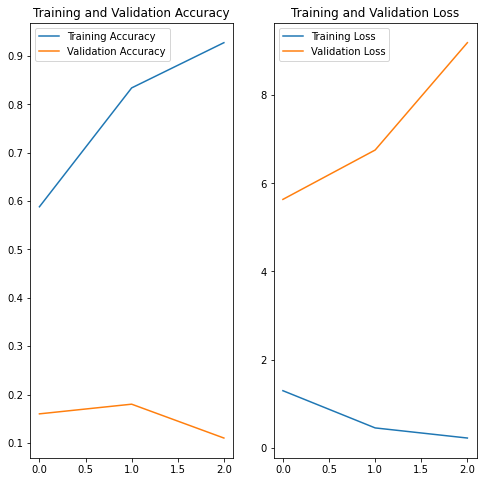

In [23]:
acc_plot(num_epochs)

As we can see that all these models are showing very high tendency to overfit, apart from that there seems to be very little difference in performance, so lets go with Model 2 (32 batch size and 15 frames), since it has fewest number of parameters

#### Model 2 -- Full Run (15 Epochs)

In [24]:
num_epochs = 15

In [25]:
m2=base_model()
m2.initialize_path('Project_data')
m2.initialize_image_properties(image_height=120,image_width=120)
m2.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=num_epochs)
model_m2=m2.define_model()
model_m2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_25 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_26 (Batc (None, 7, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 3, 30, 30, 64)    

In [26]:
model_2_full = m2.train_model(model_m2)

Epoch 1/15
21/21 [==============================] - 19s 818ms/step - loss: 1.5687 - categorical_accuracy: 0.4895 - val_loss: 1.7964 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2022-05-1113_42_09.516668\model-00001-1.25217-0.56712-1.79637-0.24000.h5
Epoch 2/15
21/21 [==============================] - 16s 802ms/step - loss: 0.5006 - categorical_accuracy: 0.8404 - val_loss: 3.0933 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2022-05-1113_42_09.516668\model-00002-0.46863-0.83861-3.09333-0.23000.h5
Epoch 3/15
21/21 [==============================] - 16s 796ms/step - loss: 0.1893 - categorical_accuracy: 0.9416 - val_loss: 3.4038 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2022-05-1113_42_09.516668\model-00003-0.18550-0.93665-3.40375-0.23000.h5
Epoch 4/15
21/21 [==============================] - 16s 770ms/step - loss: 0.1040 - categorical_accuracy: 0.9735 - val_loss: 5.1323 - val_categorical_accurac

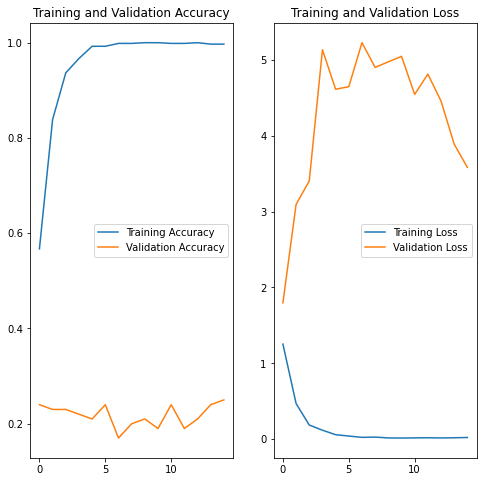

In [27]:
acc_plot(num_epochs)

We can see that the model is still overfitting tremendously, so let us play around with batch size, to see if we can reduce the overfitting to some extent

#### Model 6 - Ablation

Model 6 with batch size 15 and 20 number of frames/images to be used 

In [28]:
num_epochs = 3

In [29]:
m6=base_model()
m6.initialize_path('Project_data')
m6.initialize_image_properties(image_height=120,image_width=120)
m6.initialize_hyperparams(frames_to_sample=20,batch_size=15,num_epochs=num_epochs)
m6_ab=m6.define_model()
m6_ab.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_30 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_31 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 5, 30, 30, 64)    

In [30]:
model_6_ab = m6.train_model(m6_ab)

Epoch 1/3
45/45 [==============================] - 24s 489ms/step - loss: 1.4694 - categorical_accuracy: 0.4982 - val_loss: 7.2613 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-05-1113_46_18.428062\model-00001-1.21214-0.56259-7.26127-0.16000.h5
Epoch 2/3
45/45 [==============================] - 21s 486ms/step - loss: 0.5742 - categorical_accuracy: 0.7897 - val_loss: 10.2722 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2022-05-1113_46_18.428062\model-00002-0.55271-0.80090-10.27220-0.26000.h5
Epoch 3/3
45/45 [==============================] - 22s 486ms/step - loss: 0.2793 - categorical_accuracy: 0.9107 - val_loss: 9.4871 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2022-05-1113_46_18.428062\model-00003-0.27678-0.90498-9.48713-0.22000.h5


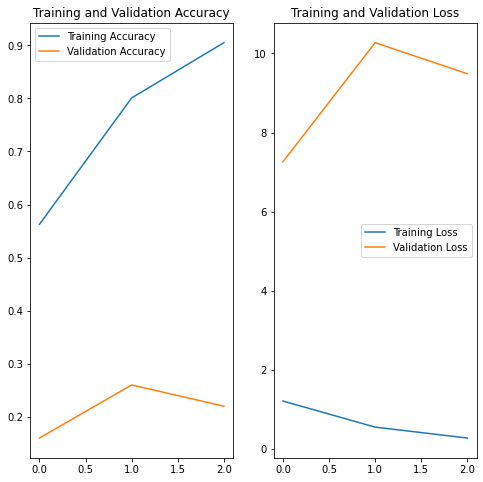

In [31]:
acc_plot(num_epochs)

#### Model 7 - Ablation

Model 7 with batch size 20 and 20 number of frames/images to be used 

In [32]:
m7=base_model()
m7.initialize_path('Project_data')
m7.initialize_image_properties(image_height=120,image_width=120)
m7.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=num_epochs)
m7_ab=m7.define_model()
m7_ab.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_35 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_36 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 5, 30, 30, 64)    

In [33]:
model_7_ab = m7.train_model(m7_ab)

Epoch 1/3
34/34 [==============================] - 24s 653ms/step - loss: 1.5385 - categorical_accuracy: 0.4855 - val_loss: 4.4439 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-05-1113_47_26.383076\model-00001-1.19794-0.58824-4.44391-0.16000.h5
Epoch 2/3
34/34 [==============================] - 22s 649ms/step - loss: 0.4389 - categorical_accuracy: 0.8379 - val_loss: 5.8080 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2022-05-1113_47_26.383076\model-00002-0.47352-0.82504-5.80798-0.16000.h5
Epoch 3/3
34/34 [==============================] - 21s 639ms/step - loss: 0.2540 - categorical_accuracy: 0.9199 - val_loss: 4.8877 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2022-05-1113_47_26.383076\model-00003-0.28047-0.91403-4.88774-0.22000.h5


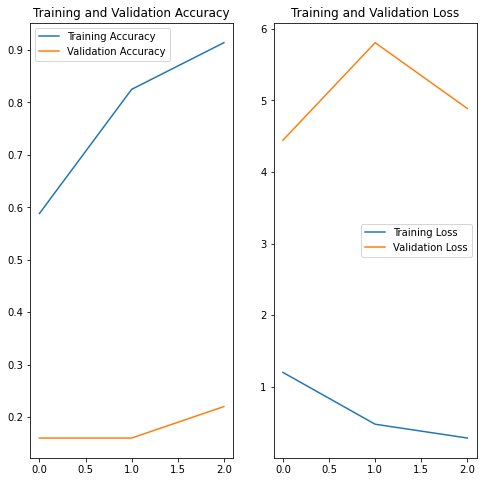

In [34]:
acc_plot(num_epochs)

#### Model 8 - Ablation

Model 8 with batch size 20 and 24 number of frames/images to be used 

In [35]:
m8=base_model()
m8.initialize_path('Project_data')
m8.initialize_image_properties(image_height=120,image_width=120)
m8.initialize_hyperparams(frames_to_sample=24,batch_size=20,num_epochs=num_epochs)
m8_ab=m8.define_model()
m8_ab.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 24, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_40 (Batc (None, 24, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_41 (Batc (None, 12, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 6, 30, 30, 32)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 6, 30, 30, 64)    

In [36]:
model_8_ab = m8.train_model(m8_ab)

Epoch 1/3
34/34 [==============================] - 29s 788ms/step - loss: 1.3919 - categorical_accuracy: 0.5433 - val_loss: 2.6338 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to model_init_2022-05-1113_48_34.430525\model-00001-1.07233-0.62293-2.63384-0.17000.h5
Epoch 2/3
34/34 [==============================] - 26s 782ms/step - loss: 0.3553 - categorical_accuracy: 0.8655 - val_loss: 5.3930 - val_categorical_accuracy: 0.1400

Epoch 00002: saving model to model_init_2022-05-1113_48_34.430525\model-00002-0.33097-0.87330-5.39299-0.14000.h5
Epoch 3/3
34/34 [==============================] - 26s 769ms/step - loss: 0.2883 - categorical_accuracy: 0.8990 - val_loss: 3.1112 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_init_2022-05-1113_48_34.430525\model-00003-0.29846-0.89744-3.11120-0.28000.h5


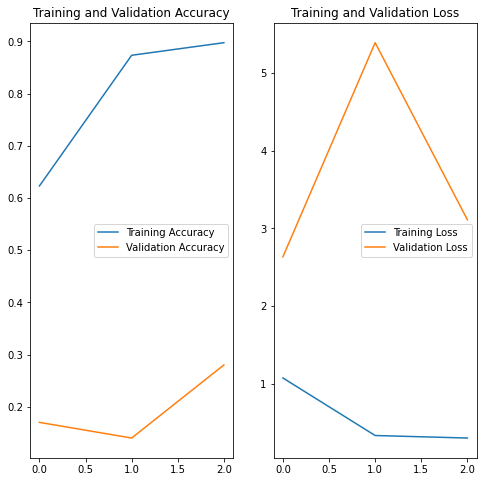

In [37]:
acc_plot(num_epochs)

Again all three models are showing tendency to overfit, so lets go with full run of 6th model since it contains fewest parameters.

#### Model 6 - Full Run

Model 6 with batch size 15 and 20 frames/images to be used 

In [38]:
num_epochs = 15

In [39]:
m6=base_model()
m6.initialize_path('Project_data')
m6.initialize_image_properties(image_height=120,image_width=120)
m6.initialize_hyperparams(frames_to_sample=20,batch_size=15,num_epochs=num_epochs)
m6_full=m6.define_model()
m6_full.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_45 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_46 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 5, 30, 30, 64)    

In [40]:
model_6 = m6.train_model(m6_full)

Epoch 1/15
45/45 [==============================] - 24s 486ms/step - loss: 1.5575 - categorical_accuracy: 0.4791 - val_loss: 3.1024 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2022-05-1113_49_55.916599\model-00001-1.33229-0.52338-3.10236-0.20000.h5
Epoch 2/15
45/45 [==============================] - 22s 484ms/step - loss: 0.7001 - categorical_accuracy: 0.7522 - val_loss: 12.9841 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-05-1113_49_55.916599\model-00002-0.65967-0.75264-12.98411-0.20000.h5
Epoch 3/15
45/45 [==============================] - 21s 477ms/step - loss: 0.3979 - categorical_accuracy: 0.8522 - val_loss: 16.2738 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2022-05-1113_49_55.916599\model-00003-0.35210-0.87029-16.27378-0.21000.h5
Epoch 4/15
45/45 [==============================] - 21s 483ms/step - loss: 0.2867 - categorical_accuracy: 0.9115 - val_loss: 18.5251 - val_categorical_ac

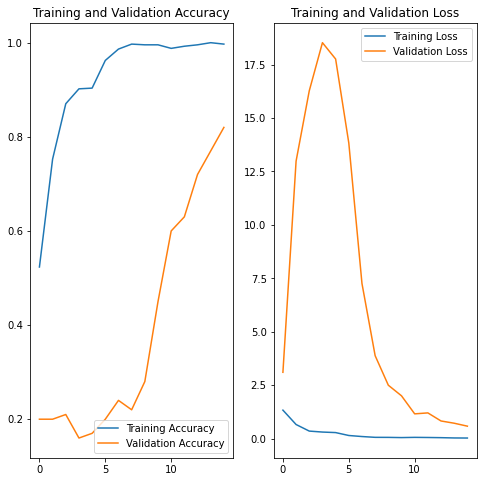

In [41]:
acc_plot(num_epochs)

We can see that performance of the model has greatly increased, but still it overfitting as evident by the huge difference in accuracies and also spikes shown in our plot.

So let us try to counter overfitting by increasing the number of epochs (to 25 from 15) and also implement minor augmentation. 

#### Model 6 - Increasing Epochs with Augmentation

In [42]:
num_epochs = 25

In [43]:
m6=base_model()
m6.initialize_path('Project_data')
m6.initialize_image_properties(image_height=120,image_width=120)
m6.initialize_hyperparams(frames_to_sample=20,batch_size=12,num_epochs=num_epochs)
m6_aug=m6.define_model()
m6_aug.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_50 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_51 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 5, 30, 30, 64)   

In [44]:
model_6_aug = m6.train_model(m6_aug,augment_data=True)

Epoch 1/25
56/56 [==============================] - 46s 782ms/step - loss: 1.8237 - categorical_accuracy: 0.4400 - val_loss: 4.8438 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-05-1113_55_21.346168\model-00001-1.49091-0.50905-4.84377-0.16000.h5
Epoch 2/25
56/56 [==============================] - 43s 774ms/step - loss: 0.7975 - categorical_accuracy: 0.7003 - val_loss: 4.9292 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2022-05-1113_55_21.346168\model-00002-0.84170-0.68175-4.92917-0.16000.h5
Epoch 3/25
56/56 [==============================] - 43s 780ms/step - loss: 0.7645 - categorical_accuracy: 0.7125 - val_loss: 4.2369 - val_categorical_accuracy: 0.1900

Epoch 00003: saving model to model_init_2022-05-1113_55_21.346168\model-00003-0.72252-0.72474-4.23691-0.19000.h5
Epoch 4/25
56/56 [==============================] - 43s 782ms/step - loss: 0.5506 - categorical_accuracy: 0.8007 - val_loss: 3.6742 - val_categorical_accurac

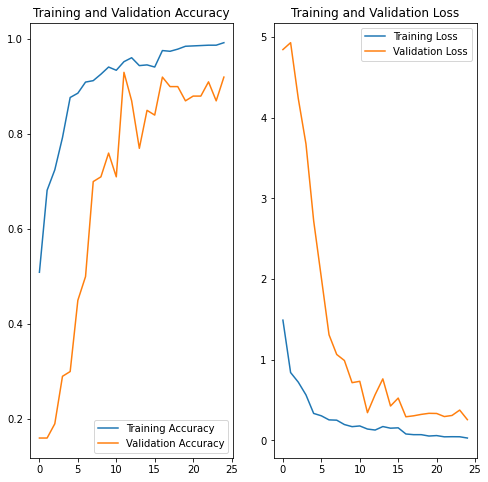

In [45]:
acc_plot(num_epochs)

We can see that the performance of model has improved by a very fine margin in terms of consistency but the training time has nearly doubled so let us try another approach,

 
1. <b> We will remove the data augmentation, (because it practically doubles our training time)</b>
2. <b> Increase dropout value (to 0.5 from 0.25) and </b>
3. <b> Add another layer of maxpooling to both reduce the number of parameters and counter overfitting </b>

In [46]:
num_epochs = 25

In [47]:
class base_model_2(ModGen):
    
    def define_model(self):

        model = Sequential()


        model.add(Conv3D(16, kernel_size = (3,3,3),padding = 'Same', activation ='relu', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels))) 
        model.add(BatchNormalization())                                                         
        model.add(MaxPooling3D(pool_size=(2,2,2)))


        model.add(Conv3D(32, kernel_size = (3,3,3),padding = 'Same', activation ='relu')) 
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))          


        model.add(Conv3D(64, kernel_size = (3,3,3),padding = 'Same', activation ='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))          
        
        
        model.add(Conv3D(64, kernel_size = (3,3,3),padding = 'Same', activation ='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))      # Adding new maxpooling layer
        
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())


        model.add(Dropout(0.5))                        # Increasing dropouts


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
m6_2=base_model_2()
m6_2.initialize_path('Project_data')
m6_2.initialize_image_properties(image_height=120,image_width=120)
m6_2.initialize_hyperparams(frames_to_sample=20,batch_size=12,num_epochs=num_epochs)
model_m6_2=m6_2.define_model()
model_m6_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_55 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_56 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 5, 30, 30, 64)   

In [49]:
model_m6_2 = m6.train_model(model_m6_2)

Epoch 1/25
56/56 [==============================] - 24s 396ms/step - loss: 1.8825 - categorical_accuracy: 0.3609 - val_loss: 4.5793 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-05-1114_13_21.695672\model-00001-1.51837-0.44646-4.57928-0.21000.h5
Epoch 2/25
56/56 [==============================] - 22s 389ms/step - loss: 0.8494 - categorical_accuracy: 0.6900 - val_loss: 5.0612 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2022-05-1114_13_21.695672\model-00002-0.78278-0.71795-5.06116-0.22000.h5
Epoch 3/25
56/56 [==============================] - 21s 383ms/step - loss: 0.5789 - categorical_accuracy: 0.7667 - val_loss: 6.2623 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2022-05-1114_13_21.695672\model-00003-0.54184-0.79487-6.26228-0.20000.h5
Epoch 4/25
56/56 [==============================] - 21s 387ms/step - loss: 0.3280 - categorical_accuracy: 0.8977 - val_loss: 5.9885 - val_categorical_accurac

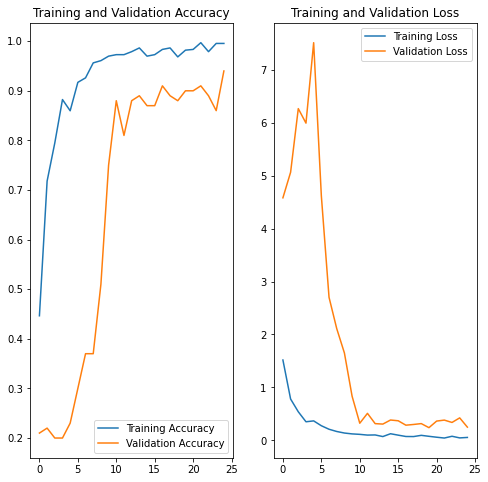

In [50]:
acc_plot(num_epochs)

We can see that the model is performing really good, with very few parameters and in less time.

Now lets try another architecture in CNN-RNN based network.

### CNN-RNN Models

##### LSTM Model

Let us use LSTM based RNN network

In [51]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM




class CNN_RNN(ModGen):
    
    def define_model(self):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
       
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(128))
        model.add(Dropout(0.25))
        
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
num_epochs = 20

In [53]:
lstm_1=CNN_RNN()
lstm_1.initialize_path('project_data')
lstm_1.initialize_image_properties(image_height=120,image_width=120)
lstm_1.initialize_hyperparams(frames_to_sample=20,batch_size=12,num_epochs=num_epochs)
lstm_1_model=lstm_1.define_model()
lstm_1_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 64)  

In [54]:
lstm_1_model = lstm_1.train_model(lstm_1_model,augment_data=True)

Epoch 1/20
56/56 [==============================] - 56s 821ms/step - loss: 1.4688 - categorical_accuracy: 0.3606 - val_loss: 1.9932 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2022-05-1114_22_21.908294\model-00001-1.33366-0.44796-1.99316-0.24000.h5
Epoch 2/20
56/56 [==============================] - 44s 795ms/step - loss: 1.0387 - categorical_accuracy: 0.5947 - val_loss: 1.9017 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2022-05-1114_22_21.908294\model-00002-0.97152-0.62971-1.90173-0.21000.h5
Epoch 3/20
56/56 [==============================] - 45s 813ms/step - loss: 0.7817 - categorical_accuracy: 0.7151 - val_loss: 2.1838 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2022-05-1114_22_21.908294\model-00003-0.78823-0.70437-2.18382-0.22000.h5
Epoch 4/20
56/56 [==============================] - 45s 805ms/step - loss: 0.6113 - categorical_accuracy: 0.7742 - val_loss: 2.1728 - val_categorical_accurac

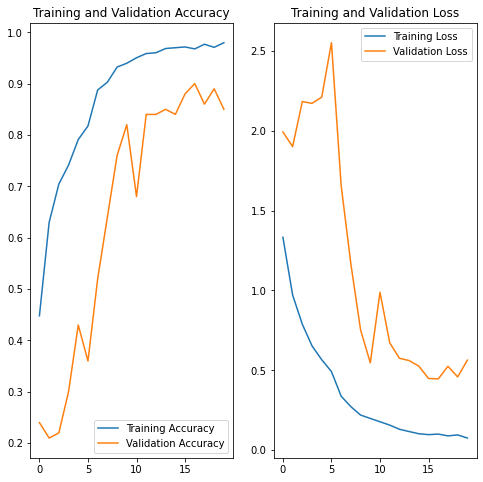

In [55]:
acc_plot(num_epochs)

We can see that the performance is quite descent but the model is still overfitting.

Now let us try Transfer learning based CNN-RNN architecture.

##### Transfer Learning Model based on  MobileNet

In [56]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class mobile_lstm(ModGen):
    
    def define_model(self):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(128))
        model.add(Dropout(0.25))
        
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [57]:
mobile_lstm=mobile_lstm()
mobile_lstm.initialize_path('project_data')
mobile_lstm.initialize_image_properties(image_height=120,image_width=120)
mobile_lstm.initialize_hyperparams(frames_to_sample=20,batch_size=12,num_epochs=num_epochs)
mobile_lstm_model=mobile_lstm.define_model()
mobile_lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)             

In [58]:
TL_model = mobile_lstm.train_model(mobile_lstm_model)

Epoch 1/20
56/56 [==============================] - 42s 492ms/step - loss: 1.4025 - categorical_accuracy: 0.3774 - val_loss: 0.6914 - val_categorical_accuracy: 0.7400

Epoch 00001: saving model to model_init_2022-05-1114_37_10.365385\model-00001-1.08783-0.54148-0.69139-0.74000.h5
Epoch 2/20
56/56 [==============================] - 23s 419ms/step - loss: 0.3772 - categorical_accuracy: 0.8678 - val_loss: 0.5654 - val_categorical_accuracy: 0.7800

Epoch 00002: saving model to model_init_2022-05-1114_37_10.365385\model-00002-0.39106-0.87330-0.56543-0.78000.h5
Epoch 3/20
56/56 [==============================] - 23s 417ms/step - loss: 0.2202 - categorical_accuracy: 0.9340 - val_loss: 0.5160 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2022-05-1114_37_10.365385\model-00003-0.20604-0.93665-0.51604-0.84000.h5
Epoch 4/20
56/56 [==============================] - 23s 418ms/step - loss: 0.2852 - categorical_accuracy: 0.9062 - val_loss: 0.5053 - val_categorical_accurac

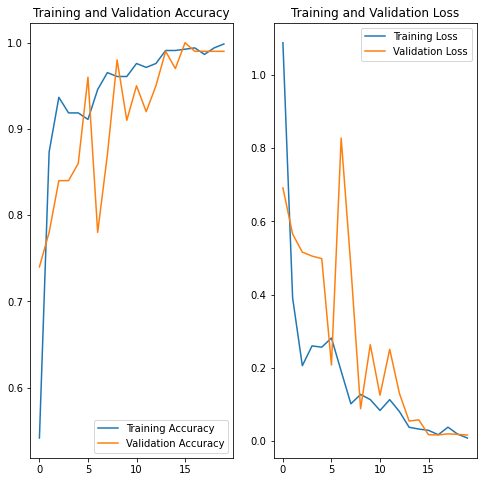

In [59]:
acc_plot(num_epochs)

<b> This Model is our final model </b>

The model is giving out a quite descent performance, although the spikes do show a very slight overfitting, 

We will be selecting the TL model (based on mobile_lstm) as our final model, since it is outperforming all other models.